In [4]:
import sys
import subprocess
packages = ['torch', 'numpy', 'matplotlib', 'pillow', 'scikit-learn', 'pandas']
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
        print(f"✓ {package} installed")
    except Exception as e:
        print(f"✗ {package} failed: {e}")

✓ torch installed
✓ numpy installed
✓ matplotlib installed
✓ pillow installed
✓ scikit-learn installed
✓ pandas installed


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import torch
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(np.int64)

x_train = X[:60000].reshape(-1, 28, 28)
y_train = y[:60000]
x_test = X[60000:].reshape(-1, 28, 28)
y_test = y[60000:]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

PyTorch version: 2.9.1
MPS available: True
Loading MNIST from OpenML...
MNIST loaded successfully
x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as f

class NN(nn.Module):
  def __init__(self, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, output_size)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    if len(x.shape) > 2:
        x = x.view(x.size(0), -1)
    x = f.relu(self.fc1(x))
    x = self.dropout(x)
    x = f.relu(self.fc2(x))
    x = self.dropout(x)
    x = self.fc3(x)
    return x




In [8]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
  def __init__(self, images,labels):
    self.images = images
    self.labels = labels
  def __len__(self):
    return len(self.images)
  def __getitem__(self,idx):
    image = self.images[idx]
    label = self.labels[idx]
    return image,label

In [9]:
train_data = DataLoader(dataset(x_train,y_train),batch_size=64,shuffle=True)
test_data = DataLoader(dataset(x_test,y_test), batch_size=32, shuffle=False)

In [10]:
batch_size = 64
num_epochs = 5
learning_rate = 0.001
input_size = 28*28
output_size = 10

In [19]:
model = NN(output_size= output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  for images, labels in train_data:
    images = images.float()
    labels = labels.long()
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  
  epoch_loss = running_loss / len(train_data)
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/5, Loss: 0.3459
Epoch 2/5, Loss: 0.1498
Epoch 3/5, Loss: 0.1161
Epoch 4/5, Loss: 0.0945
Epoch 5/5, Loss: 0.0800


In [21]:
model.eval()
correct = 0
total = 0

for images, labels in test_data:
   images = images.float()
   labels = labels.long()
   output = model(images)
   correct += (output.argmax(1) == labels).sum().item()
   total += labels.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.81%


 Index  Expected  Predicted Confidence Correct
     3         0          0     99.78%       ✓
     2         1          1     99.97%       ✓
     1         2          2     99.98%       ✓
    18         3          3     70.03%       ✓
     4         4          4     99.94%       ✓
     8         5          5     78.09%       ✓
    11         6          6     99.95%       ✓
     0         7          7     99.99%       ✓
    61         8          8     97.72%       ✓
     7         9          9     98.62%       ✓

Accuracy: 10/10


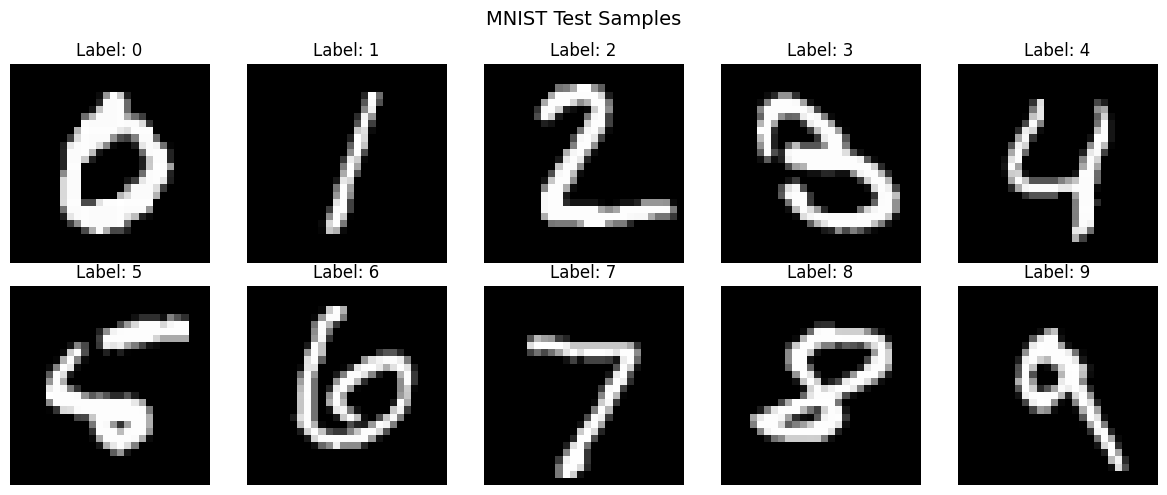

In [27]:
results = []
sample_indices = [np.where(y_test == digit)[0][0] for digit in range(10)]

for digit, idx in enumerate(sample_indices):
    img_array = x_test[idx]
    label = y_test[idx]
    
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).float()
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prediction = output.argmax(1).item()
        confidence = torch.softmax(output, dim=1)[0][prediction].item() * 100
    
    results.append({
        'Index': idx,
        'Expected': label,
        'Predicted': prediction,
        'Confidence': f'{confidence:.2f}%',
        'Correct': '✓' if prediction == label else '✗'
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))
print(f"\nAccuracy: {sum(1 for r in results if r['Correct'] == '✓')}/10")

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, idx in enumerate(sample_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(x_test[idx], cmap='gray')
    ax.set_title(f'Label: {y_test[idx]}')
    ax.axis('off')
plt.suptitle('MNIST Test Samples', fontsize=14)
plt.tight_layout()
plt.show()